# Clase 15: Polinomios osculantes y spline cúbica

## Polinomios osculantes

Ahora queremos requerir que nuestros polinomios no sólo pasen por todos los puntos entre los cuales se quiere interpolar, si no que además coincidan también sus derivadas. Este caso no se da con mucha frecuencia ya que es raro tener las derivadas de una función que se quiere interpolar, pero puede ser de alguna utilidad.

Los polinomios que satisfacen

$$
P(x_i) = f(x_i)\,,\quad P'(x_i) = f'(x_i)\,,
$$

en $n$ puntos, se llaman polinomios de Hermite. Estos polinomios deben ser de grado $2n$ para satisfacer estas condiciones. 

Un modo de obtener los polinomios de Hermite es a través de las diferencias divididas. Sólo que ahora contamos cada punto dos veces: $z_{2i} = z_{2i + 1} = x_i$. Además tomamos por definición

$$
f[z_{2i}, z_{2i + 1}] = f'(x_i).
$$

El polinomio de Hermite está entonces dado por

$$
P(x) = f[z_o] + \sum_{k=1}^{2n + 1} f[z_o, ..., z_k] (z - z_o)...(z - z_{k-1})
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def hermite(puntos):
    
    n = len(puntos) - 1
    zs = np.zeros(2*n + 2) # Creamos el doble de puntos
    Fs = [np.zeros(2*n + 2), np.zeros(2*n + 1)] # Creamos las primeras columnas de f[]
    
    # Llenamos las dos primeras columnas de f[]
    for i in range(n + 1):
        zs[2*i] = puntos[i][0]
        zs[2*i + 1] = puntos[i][0]
        Fs[0][2*i] = puntos[i][1]
        Fs[0][2*i+1] = puntos[i][1]
        Fs[1][2*i] = puntos[i][2]
        if i != 0:
            Fs[1][2*i-1] = (Fs[0][2*i] - Fs[0][2*i-1])/(zs[2*i] - zs[2*i-1])
            
    # Calculamos las diferencias divididas
    for i in range(2, 2*n + 2):
        Fs.append(np.zeros(2*n + 2 - i))
        for j in range(2, i + 1):
            Fs[j][i-j] = (Fs[j-1][i-j+1] - Fs[j-1][i-j])/(zs[i] - zs[i-j])
    
    return [Fs[i][0] for i in range(2*n + 2)]

In [3]:
puntos = [[1.3, 0.6200860, -0.5220232], [1.6, 0.4554022, -0.5698959], [1.9, 0.2818186, -0.5811571]]

In [4]:
coefs = hermite(puntos)

In [5]:
def poly_hermite(x, coefs, puntos):
    zs = [puntos[n//2][0] for n in range(len(coefs))]
    s = 0
    terms = [(x - zs[i]) for i in range(len(coefs))]
    for n in range(len(coefs)):
        s += coefs[n]*np.prod(terms[:n])
    return s

In [6]:
poly_hermite(1.5, coefs, puntos)

0.5118277017283951

Hagamos un ejemplo. Interpolemos la función de $1/x$ entre $0.2$ y $2$ usando tres puntos usando un polinomio de Lagrange y luego usando un polinomio de Hermite.

In [7]:
def difer(puntos):
    
    n = len(puntos) - 1
    Fs = [np.zeros(n + 1)]
    for i in range(n + 1):
        Fs[0][i] = puntos[i][1]
    for i in range(1, n + 1):
        Fs.append(np.zeros(n + 1 - i))
        for j in range(1, i + 1):
            Fs[j][i-j] = (Fs[j-1][i-j+1] - Fs[j-1][i-j])/(puntos[i][0] - puntos[i-j][0])
    
    return [Fs[i][0] for i in range(n + 1)]

In [8]:
puntos = np.array([[0.5, 1/0.5, -1/0.5**2], [1,1,-1], [2,1/2,-1/4]])

In [9]:
coefs_lagrange = difer(puntos)

In [10]:
def poly_lagrange(x, coefs, puntos):
    return sum(coefs[n]*np.prod([(x - puntos[i,0]) for i in range(n)]) for n in range(len(coefs)))

In [11]:
coefs_hermite = hermite(puntos)

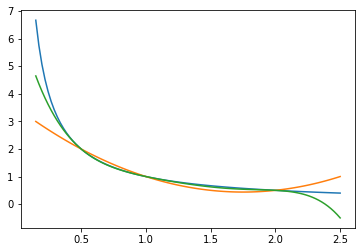

In [12]:
x = np.linspace(0.15, 2.5, 100)
exact = 1/x
lag = [poly_lagrange(xi, coefs_lagrange, puntos) for xi in x]
her = [poly_hermite(xi, coefs_hermite, puntos) for xi in x]

plt.plot(x, exact)
plt.plot(x, lag)
plt.plot(x, her)

## Splines cúbicas

Los polinomios de alto orden tienen problemas al intentar interpolar una función. Intentemos un ejemplo tomando muchos puntos.

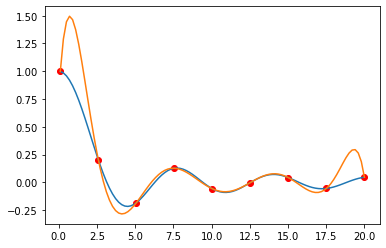

In [13]:
mini = 0.1
maxi = 20
order = 9

xp = np.linspace(mini, maxi, order)
puntos = np.array([[xi, np.sin(xi)/xi] for xi in xp])
coefs_lagrange = difer(puntos)

x = np.linspace(mini, maxi, 100)
exact = np.sin(x)/x
lag = [poly_lagrange(xi, coefs_lagrange, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, exact)
plt.plot(x, lag)

Lo mismo ocurre cuando los puntos de datos contienen un error numérico.

Por este motivo es más práctico hacer una interpolación de la función tramo por tramo.

In [14]:
def find_ind(x, puntos):
    for i in range(len(puntos)):
        if x < puntos[i,0] and i != 0:
            return i-1

def lin_interp(x, puntos):
    if x >= puntos[len(puntos)-1,0]:
        return puntos[len(puntos)-1,1]
    elif x <= puntos[0,0]:
        return puntos[0,1]
    
    i = find_ind(x, puntos)
    Lo = puntos[i][1]*(x - puntos[i+1][0])/(puntos[i][0] - puntos[i+1][0])
    L1 = puntos[i+1][1]*(x - puntos[i][0])/(puntos[i+1][0] - puntos[i][0])
    return Lo + L1

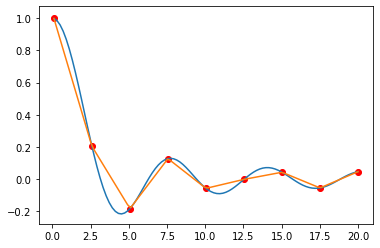

In [15]:
mini = 0.1
maxi = 20
order = 9

xp = np.linspace(mini, maxi, order)
puntos = np.array([[xi, np.sin(xi)/xi] for xi in xp])

x = np.linspace(mini, maxi, 100)
exact = np.sin(x)/x
lin = [lin_interp(xi, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, exact)
plt.plot(x, lin)

Para lograr un mejor ajuste (más suave) podemos imponer más condiciones. Por ejemplo podemos pedir que la derivada sea igual a la derivada de la función que queremos interpolar. Pero con frecuencia no tenemos la derivada de la función.

Sea $S_i$ el polinomio que interpola entre los puntos $x_i$ y $x_{i+1}$. Podemos pedir que la derivada de la interpolación sea continua, es decir 

$$
S_{i}'(x_{i+1}) = S_{i+1}'(x_{i+1})
$$

Estas son $n - 2$ condiciones adicionales (sobre las $2n - 2$ condiciones $S_{i}(x_i) = f(x_i)$ y $S_{i}(x_{i+1}) = f(x_{i+1})$). Tendremos $n-1$ polinomios interpolantes, tal que para lograr imponer estas condiciones es neceario usar polinomios cuadráticos, cada uno de los cuales contiene tres coeficientes para un total de $3n - 3$. 

El tipo de polinomios más usados tienen una condición sobre las anteriores

$$
S_{i}''(x_{i+1}) = S_{i+1}''(x_{i+1})
$$

Ahora tendremos $4n - 6$ condiciones. Para cumplirlas necesitamos polinomios de orden al menos cúbico, para un total de $4n - 4$ coeficientes libres. A estos polinomios se los llama splines cúbicas. Pero para fijarlos completamente falta una condición. Escogemos la que es más útil en la práctica

$$
S_0''(x_o) = S_{n-1}''(x_n) = 0
$$

A estas se las llama splines naturales. Se pueden encontrar resolviendo un sistema de $4n - 4$ ecuaciones.

In [16]:
def spline_coefs(puntos):
    
    n = len(puntos) - 1
    
    h = np.zeros(n)
    for i in range(n):
        h[i] = puntos[i + 1][0] - puntos[i][0]
    
    a = puntos[:,1]
    alpha = np.zeros(n - 1)
    for i in range(1, n):
        alpha[i-1] = (3/h[i])*(a[i+1] - a[i]) - (3/h[i-1])*(a[i] - a[i-1])
        
        
    # Se resuelve un sistema de ecuaciones:
    l = np.ones(n + 1)
    mu = np.zeros(n)
    z = np.zeros(n + 1)
    for i in range(1, n):
        l[i] = 2*(puntos[i+1][0] - puntos[i-1][0]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i-1] - h[i-1]*z[i-1])/l[i]
    b = np.zeros(n)
    c = np.zeros(n+1)
    d = np.zeros(n)
    for j in range(n-1,-1,-1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1] - a[j])/h[j] - h[j]*(c[j+1] + 2*c[j])/3
        d[j] = (c[j+1] - c[j])/(3*h[j])
        
    return a, b, c, d

In [17]:
def spline_eval(x, coefs, puntos):

    if x >= puntos[-1,0]:
        return puntos[-1,1]
    elif x <= puntos[0,0]:
        return puntos[0,1]
    
    i = find_ind(x, puntos)
    a, b, c, d = coefs
    return (a[i] + b[i]*(x - puntos[i][0]) + \
            c[i]*(x - puntos[i][0])**2 + d[i]*(x - puntos[i][0])**3)

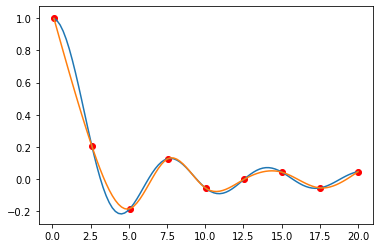

In [20]:
mini = 0.1
maxi = 20
order = 9

xp = np.linspace(mini, maxi, order)
puntos = np.array([[xi, np.sin(xi)/xi] for xi in xp])
coefs= spline_coefs(puntos)

x = np.linspace(mini, maxi, 100)
exact = np.sin(x)/x
spline = [spline_eval(xi, coefs, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, exact)
plt.plot(x, spline)



## Scipy

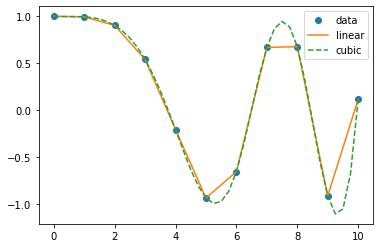

In [21]:
# Tomado de: https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html

from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

## Tareas

### Tarea 8.1

Tome 20 puntos entre $x = -2$ y $x = 2$ para interpolar la función $\tanh(x)$. Hágalo usando la spline cúbica introducida en clase y la función de scipy. ¿Cuál tiene un error mayor?

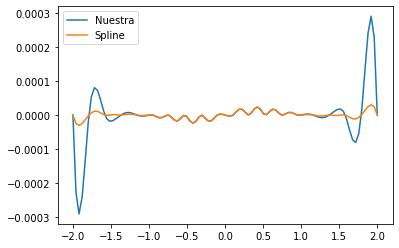

In [22]:
mini = -2
maxi = 2

xp = np.linspace(mini, maxi, 20)
puntos = np.array([[xi, np.tanh(xi)] for xi in xp])
coefs = spline_coefs(puntos)

from scipy.interpolate import interp1d
f = interp1d(xp, np.tanh(xp), kind='cubic')

x = np.linspace(mini, maxi, 100)
exact = np.tanh(x)
spline = [spline_eval(xi, coefs, puntos) for xi in x]

plt.plot(x, exact - spline, label = 'Nuestra')
plt.plot(x, exact - f(x), label = 'Spline')
plt.legend()

### Tarea 8.2

Escriba un código similar a la interpolación lineal de la clase, pero que realice una interpolación cuadrática. Es decir, este código interpola usando una parábola para cada trío de puntos. Grafique sus resultados para el mismo ejemplo usado en la interpolación lineal.

In [23]:
def find_ind2(x, puntos):
    for i in range(0, len(puntos), 2):
        if x < puntos[i,0]:
            return i-2

def quad_interp(x, puntos):
    if x >= puntos[-1,0]:
        return puntos[-1,1]
    elif x <= puntos[0,0]:
        return puntos[0,1]
    
    i = find_ind2(x, puntos)
    Lo = (x - puntos[i+1][0])*(x - puntos[i+2][0])/((puntos[i][0] - puntos[i+1][0])*(puntos[i][0] - puntos[i+2][0]))
    L1 = (x - puntos[i][0])*(x - puntos[i+2][0])/((puntos[i+1][0] - puntos[i][0])*(puntos[i+1][0] - puntos[i+2][0]))
    L2 = (x - puntos[i][0])*(x - puntos[i+1][0])/((puntos[i+2][0] - puntos[i][0])*(puntos[i+2][0] - puntos[i+1][0]))
    return puntos[i][1]*Lo + puntos[i+1][1]*L1 + puntos[i+2][1]*L2

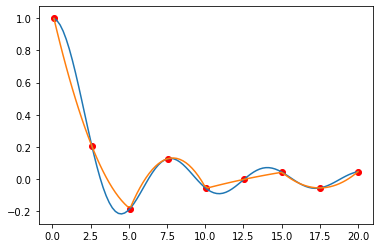

In [24]:
mini = 0.1
maxi = 20
order = 9

xp = np.linspace(mini, maxi, order)
puntos = np.array([[xi, np.sin(xi)/xi] for xi in xp])

x = np.linspace(mini, maxi, 100)
exact = np.sin(x)/x
quad = [quad_interp(xi, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, exact)
plt.plot(x, quad)

### Tarea 8.3

Considere una curva gaussiana con media $0$ y varianza $1$. Aproxime esta curva con una spline cúbica usando 5 puntos entre $x = 0$ y $x = 2$. Use esta spline para calcular la integral de la función. Compare el resultado con su valor exacto (ver la función de error de tareas anteriores).

In [57]:
def gauss(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-x*x/2)

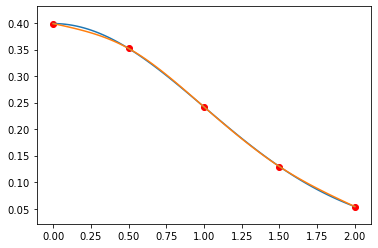

In [70]:
mini = 0
maxi = 2
num = 5

xp = np.linspace(mini, maxi, num)
puntos = np.array([[xi, gauss(xi)] for xi in xp])
coefs= spline_coefs(puntos)

x = np.linspace(mini, maxi, 100)
exact = gauss(x)
spline = [spline_eval(xi, coefs, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, exact)
plt.plot(x, spline)

In [71]:
def integ_single_spline(coefs, xmin, xmax):
    a, b, c, d = coefs
    dx = xmax - xmin
    return a*dx + (b/2)*dx**2 + (c/3)*dx**3 + (d/4)*dx**4

def integ_spline(coefs, puntos):
    s = 0
    for i in range(len(puntos)-1):
        a, b, c, d = coefs[0][i], coefs[1][i], coefs[2][i], coefs[3][i]
        s += integ_single_spline((a, b, c, d), puntos[i][0], puntos[i+1][0])
        
    return s

In [72]:
coefs

(array([0.39894228, 0.35206533, 0.24197072, 0.1295176 , 0.05399097]),
 array([-0.06154305, -0.15817563, -0.24758377, -0.18677568]),
 array([ 0.        , -0.19326517,  0.01444889,  0.10716728,  0.        ]),
 array([-0.12884345,  0.13847604,  0.06181225, -0.07144485]))

In [78]:
approx = integ_spline(coefs, puntos)

Comparamos con la función de error:

$$
\frac{1}{\sqrt{2 \pi}}\int_0^{a} dx\,e^{-x^2/2} = \frac{1}{2}\text{erf}\left(a/\sqrt{2}\right)
$$

In [79]:
from scipy import special

In [80]:
exact = special.erf(2/np.sqrt(2))/2

In [81]:
np.abs((approx - exact)/exact)

0.0015653128467986303

### Tarea 8.4

Considere la función $f(x) = 4 x^3 - 3x^2 + x -5$. Use sólo dos puntos para interpolar usando una spline cúbica entre $x =-1$ y $x = 1$. Haga lo mismo con 4 puntos equidistantes. Explique por qué la spline cúbica es diferente del polinomio original si ambos son polinomios cúbicos.

In [82]:
def f(x):
    return 4*x**3-3*x**2+x-5

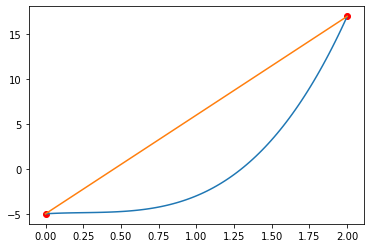

In [84]:
mini = 0
maxi = 2
num = 2

xp = np.linspace(mini, maxi, num)
puntos = np.array([[xi, f(xi)] for xi in xp])
coefs= spline_coefs(puntos)

x = np.linspace(mini, maxi, 100)
exact = f(x)
spline = [spline_eval(xi, coefs, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, exact)
plt.plot(x, spline)

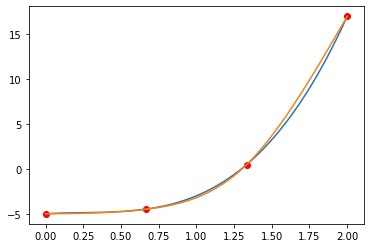

In [85]:
mini = 0
maxi = 2
num = 4

xp = np.linspace(mini, maxi, num)
puntos = np.array([[xi, f(xi)] for xi in xp])
coefs= spline_coefs(puntos)

x = np.linspace(mini, maxi, 100)
exact = f(x)
spline = [spline_eval(xi, coefs, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, exact)
plt.plot(x, spline)

La spline cúbica es un polinomio cúbico para cada pareja de puntos. En el primer caso es diferente del polinomio dado ya que la spline cúbica cumple que su segunda derivada es cero en ambos extremos, lo que no cumple el polinomio original. En el segundo caso, existe un único polinomio que pasa por cuatro puntos, pero la spline cúbica son tres polinomios diferentes.

### Tarea 8.5

Haga una interpolación con polinomios de Lagrange y con spline cúbica a los siguientes datos. Compare y explique.

In [91]:
puntos = np.array([[0.0, 0.8554428669760865],
 [0.10256410256410256, 0.8192503889643609],
 [0.20512820512820512, 0.9106698108197717],
 [0.3076923076923077, 0.8712405328999302],
 [0.41025641025641024, 1.028882810913172],
 [0.5128205128205128, 0.9042429634802972],
 [0.6153846153846154, 0.855131704289422],
 [0.717948717948718, 0.8320615040511042],
 [0.8205128205128205, 0.5404161442504423],
 [0.923076923076923, 0.4607411363876057],
 [1.0256410256410255, 0.5230079911073856],
 [1.1282051282051282, 0.4319333734735373],
 [1.2307692307692308, 0.3194709855419703],
 [1.3333333333333333, 0.3176511643072673],
 [1.435897435897436, 0.08845060273327107],
 [1.5384615384615383, -0.1118729194358061],
 [1.641025641025641, -0.05123505155215124],
 [1.7435897435897436, -0.2758484321392249],
 [1.846153846153846, -0.3354753113897514],
 [1.9487179487179487, -0.26956032827356446],
 [2.051282051282051, -0.571247853583287],
 [2.1538461538461537, -0.7087933751789464],
 [2.2564102564102564, -0.7346123839017604],
 [2.358974358974359, -0.9422578154572859],
 [2.4615384615384617, -0.6839691792454056],
 [2.564102564102564, -0.9525757587137708],
 [2.6666666666666665, -0.8747644889180131],
 [2.769230769230769, -0.9126743380349072],
 [2.871794871794872, -1.0825927238281552],
 [2.9743589743589745, -1.0103075868775828],
 [3.0769230769230766, -0.907399219424252],
 [3.1794871794871793, -0.851996743383459],
 [3.282051282051282, -0.9446601118164999],
 [3.3846153846153846, -1.0173310927863406],
 [3.4871794871794872, -0.8906772736257376],
 [3.5897435897435894, -0.896632562845944],
 [3.692307692307692, -0.8524291153089643],
 [3.7948717948717947, -0.6563668686292993],
 [3.8974358974358974, -0.8565509469076233],
 [4.0, -0.6052319246737182]])


In [92]:
def lagrange(x, puntos):
    '''
    Interpola una función que pasa por n puntos como un polinomio
    de Legendre y lo evalúa en el punto x. Los puntos deben ser
    dados como una lista de tuplas (xi, f(xi)).
    '''
    
    Lis = np.ones(len(puntos))
    fs = np.ones(len(puntos))
    for i in range(len(puntos)):
        fs[i] = puntos[i][1]
        for j in range(len(puntos)):
            if j != i:
                Lis[i] *= (x - puntos[j][0])/(puntos[i][0] - puntos[j][0])
    
    return sum(fs*Lis)

In [93]:
coefs= spline_coefs(puntos)

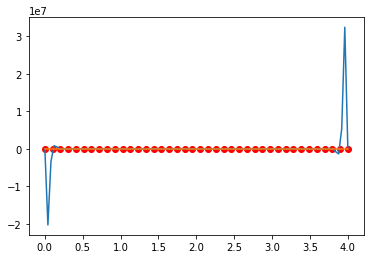

In [98]:
mini = 0
maxi = 4

x = np.linspace(mini, maxi, 100)
lag = [lagrange(xi, puntos) for xi in x]
spline = [spline_eval(xi, coefs, puntos) for xi in x]

plt.scatter(puntos[:,0], puntos[:,1], color='red')
plt.plot(x, lag)
plt.plot(x, spline)

Hacer una interpolación de muchos puntos ruidosos a un polinomio de Lagrange de muy alto orden induce grandes oscilaciones. Esto se puede ver también si reducimos el rango del gráfico

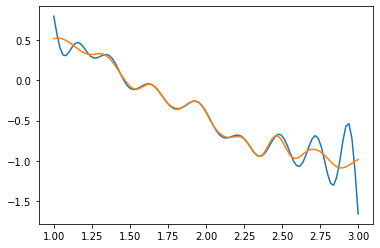

In [101]:
mini = 1
maxi = 3

x = np.linspace(mini, maxi, 100)
lag = [lagrange(xi, puntos) for xi in x]
spline = [spline_eval(xi, coefs, puntos) for xi in x]

plt.plot(x, lag)
plt.plot(x, spline)